---

"COVID-19 Open Research Data Analysis"
---

This is an analysis report of the Novel Coronavirus (COVID-19). It is focusing on data processing, visualisation and statstics for R Statistics Course.
Data provided by Johns Hopkins University [github](https://github.com/CSSEGISandData/COVID-19)



In [1]:
# This is an analysis report of the Novel Coronavirus (COVID-19)
# Aim for data processing, visualisation and statstics
# Source code: http://yanchang.rdatamining.com/
# set directory
# Data Source: 2019 Data Repository https://github.com/CSSEGISandData/COVID-19
# R Packages:
library(magrittr) # pipline operations
library(lubridate) # date operation
library(tidyverse) # data science pips
library(gridExtra) # grid based plots
library(dplyr)
library(leaflet)
library(ggforce)
library(kableExtra)

# Loading data
# At first, three CSV files, are downloaded and saved as local files
# and then loaded into R
# source data files changes everytime
filenames <- c('time_series_covid19_confirmed_global.csv',
               'time_series_covid19_deaths_global.csv', 
               'time_series_covid19_recovered_global.csv')
url.path <- paste0('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/',
                   'master/csse_covid_19_data/csse_covid_19_time_series/')

#download files to local folder
download <- function(filename) {
  url <- file.path(url.path, filename)
  dest <- file.path('./data', filename)
  download.file(url, dest)
}
bin <- lapply(filenames, download)


# load data into R
data.confirmed.original <- read.csv('./data/time_series_covid19_confirmed_global.csv')
data.deaths.original <- read.csv('./data/time_series_covid19_deaths_global.csv')
data.recovered.original <- read.csv('./data/time_series_covid19_recovered_global.csv')


# check dimension of data confirmed
dim(data.confirmed.original)

Warning message:
"package 'magrittr' was built under R version 3.6.3"Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"Warning message:
"package 'stringr' was built under R version 3.6.3"War

[1] 258  76

In [2]:
# Table:
data.confirmed.original[1:10, 1:10]


,Province.State,Country.Region,Lat,Long,X1.22.20,X1.23.20,X1.24.20,X1.25.20,X1.26.20,X1.27.20
,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
1,,Afghanistan,33.0000,65.0000,0,0,0,0,0,0
2,,Albania,41.1533,20.1683,0,0,0,0,0,0
3,,Algeria,28.0339,1.6596,0,0,0,0,0,0
4,,Andorra,42.5063,1.5218,0,0,0,0,0,0
5,,Angola,-11.2027,17.8739,0,0,0,0,0,0
6,,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0
7,,Argentina,-38.4161,-63.6167,0,0,0,0,0,0
8,,Armenia,40.0691,45.0382,0,0,0,0,0,0
9,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0


In [3]:

# check time frame of the data
n.col <- ncol(data.confirmed.original) # 58 variables
# get dates from column names
dates <- names(data.confirmed.original)[5:n.col] %>% substr(2,8) %>% mdy()
range(dates)

min.date <- min(dates)
max.date <- max(dates)
max.date.txt <- max.date %>% format('%d %b %Y')
min.date.txt <- min.date %>% format('%d %b Y')
# last update on 26 March 2020 max.date

[1] "2020-01-22" "2020-04-02"

In [4]:

# Data Preparation steps:
# 1.From wide to long format
# 2.Aggregate by country
# 3. merge into a signe dataset
# cleaning and transformation
cleanData <- function(data) {
  ## remove some columns
  data %<>% select(-c(Province.State, Lat, Long)) %>% rename(country=Country.Region) 
  ## convert from wide to long format
  data %<>% gather(key=date, value=count, -country) 
  ## convert from character to date 
  data %<>% mutate(date = date %>% substr(2,8) %>% mdy()) 
  ## aggregate by country 
  data %<>% group_by(country, date) %>% summarise(count=sum(count)) %>% as.data.frame()
  return(data)
}
# clean the three datasets
data.confirmed <- data.confirmed.original %>% cleanData() %>% rename(confirmed=count)  
data.deaths <- data.deaths.original %>% cleanData() %>% rename(deaths=count)
data.recovered <- data.recovered.original %>% cleanData() %>% rename(recovered=count)

# merge above 3 datasets into one, by country and date
data <- data.confirmed %>% merge(data.deaths, all = T) %>% merge(data.recovered, all = T)

# countries/regions with confirmed cases (excl cruise ships)
countries <- data %>% pull(country) %>% setdiff('Cruise Ship')

# last 10 records when it first broke out in Spain
data %>% filter(country =='Spain')%>% tail(10)

# counts for worldwide
data.world <- data %>% group_by(date) %>%
  summarise(country='World',
            confirmed=sum(confirmed, na.rm = T),
            deaths=sum(deaths, na.rm = T),
            recovered=sum(recovered, na.rm = T))

data %<>% rbind(data.world)

# current confirmed cases
data %<>% mutate(remaining.confirmed = confirmed - deaths - recovered)


,country,date,confirmed,deaths,recovered
,<fct>,<date>,<int>,<int>,<int>
63,Spain,2020-03-24,39885,2808,3794
64,Spain,2020-03-25,49515,3647,5367
65,Spain,2020-03-26,57786,4365,7015
66,Spain,2020-03-27,65719,5138,9357
67,Spain,2020-03-28,73235,5982,12285
68,Spain,2020-03-29,80110,6803,14709
69,Spain,2020-03-30,87956,7716,16780
70,Spain,2020-03-31,95923,8464,19259
71,Spain,2020-04-01,104118,9387,22647


In [5]:

# Daily Increases and Death Rates

# rate.upper = total deaths and recovered cases
# rate.lower = total deaths and confirmed cases
# expected death rate is to be between above rates
# rate.daily =daily deaths and recovered cases

## sort by country and date
data %<>% arrange(country,date)
# daily increases of deaths and recovered cases
# set NA to increase on day1
n <- nrow(data)
day1 <- min(data$date) # set NA day1
data %<>% mutate(confirmed.new=ifelse(date ==day1,NA, confirmed - lag(confirmed, n=1)),
                 deaths.new=ifelse(date ==day1,NA,deaths - lag(deaths, n=1)),
                 recovered.new=ifelse(date ==day1,NA,recovered - lag(recovered, n=1)))

# change negative number of new cases to 0
data %>% mutate(confirmed.new = ifelse(confirmed.new < 0,0, confirmed.new),
                deaths.new = ifelse(deaths.new < 0, 0, deaths.new),
                recovered.new= ifelse(recovered.new < 0, 0, recovered.new))

# death rate base on total deaths and recovered cases
data %<>% mutate(rate.upper = (100 *deaths / (deaths + recovered)) %>% round(1))
# lower bound: death rate based on total confirmed cases
data %<>% mutate(rate.lower = (100 * deaths / confirmed) %>% round(1))
# death rate based on number f death/recovered on every single day
data %<>% mutate(rate.daily = (100 * deaths.new / (deaths.new + recovered.new)) %>% round(1))
                                                        
# convert from wide to long format, for drawing area plot
data.long <- data %>%
  select(c(country, date, confirmed, remaining.confirmed, recovered, deaths)) %>%
  gather(key = type, value = count, -c(country,date))
# set for factor levels to show them in a desirable order
data.long %<>% mutate(type =recode_factor(type, confirmed= 'Total Confirmed',
                                          remaining.confirmed = 'Remaining Confirmed',
                                          recovered= 'Recovered',
                                          deaths='Deaths'))

# convert from wide to long format, for drawing area plots
rates.long <- data %>%
  select(c(country, date, rate.upper, rate.lower, rate.daily)) %>% 
  gather(key = type, value=count, -c(country,date))
# set factor levels for desired order
rates.long %<>% mutate(type =recode_factor(type, rate.daily = 'Daily',
                                           rate.lower = 'Lower bound',
                                           rate.upper = 'Upper bound'))

country,date,confirmed,deaths,recovered,remaining.confirmed,confirmed.new,deaths.new,recovered.new
<fct>,<date>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Afghanistan,2020-01-22,0,0,0,0,NA,NA,NA
Afghanistan,2020-01-23,0,0,0,0,0,0,0
Afghanistan,2020-01-24,0,0,0,0,0,0,0
Afghanistan,2020-01-25,0,0,0,0,0,0,0
Afghanistan,2020-01-26,0,0,0,0,0,0,0
Afghanistan,2020-01-27,0,0,0,0,0,0,0
Afghanistan,2020-01-28,0,0,0,0,0,0,0
Afghanistan,2020-01-29,0,0,0,0,0,0,0
Afghanistan,2020-01-30,0,0,0,0,0,0,0


In [6]:
# Visualisation
# After preparing the data, we portrait it in various graphs

# TOP Ten Countries
# ranking by confirmed cases
data.latest.all <- data %>% filter(date == max(date)) %>%
  select(country, date,
         confirmed, confirmed.new, remaining.confirmed, recovered, deaths.new, deaths, death.rate = rate.lower) %>% mutate(ranking = dense_rank(desc(confirmed)))
# top 20 countries incl 11 World
k<- 20
top.countries <- data.latest.all %>% filter(ranking <= k+1) %>%
  arrange(ranking) %>% pull(country) %>% as.character()
top.countries %>% setdiff('World') %>% print()


 [1] "US"             "Italy"          "Spain"          "Germany"       
 [5] "China"          "France"         "Iran"           "United Kingdom"
 [9] "Switzerland"    "Turkey"         "Belgium"        "Netherlands"   
[13] "Canada"         "Austria"        "Korea, South"   "Portugal"      
[17] "Brazil"         "Israel"         "Sweden"         "Norway"        


In [7]:
names(data.latest.all)
## add 'Others'
top.countries %<>% c('Others')
## put all others in a single group of 'Others'
data.latest <- data.latest.all %>% filter(!is.na(country)) %>%
mutate(country=ifelse(ranking <= k + 1, as.character(country), 'Others')) %>%
mutate(country=country %>% factor(levels=c(top.countries)))

data.latest %<>% group_by(country) %>%
  summarise(confirmed=sum(confirmed), confirmed.new=sum(confirmed.new), remaining.confirmed = sum(remaining.confirmed), recovered = sum(recovered),deaths=sum(deaths), deaths.new = sum(deaths.new)) %>%
              mutate(death.rate=(100*deaths/confirmed) %>% round(1))
data.latest %<>% select(c(country, confirmed, deaths,death.rate, confirmed.new, deaths.new,remaining.confirmed))

data.latest %>% mutate(death.rate=death.rate %>% format(nsmall=1) %>% paste0('%')) %>% kable('latex', booktabs=T, row.names=T, align=c('l', rep('r', 6)), caption=paste0('Cases in Top 20 Countries - ', max.date.txt,'.'), format.args=list(big.mark=',')) %>% kable_styling(font_size=7, latex_options=c('striped', 'hold_position', 'repeat_header'))


[1] "country"             "date"                "confirmed"          
 [4] "confirmed.new"       "remaining.confirmed" "recovered"          
 [7] "deaths.new"          "deaths"              "death.rate"         
[10] "ranking"

\begin{table}[!h]

\caption{\label{tab:}Cases in Top 20 Countries - 02 Apr 2020.}
\centering
\fontsize{7}{9}\selectfont
\begin{tabular}[t]{llrrrrrr}
\toprule
  & country & confirmed & deaths & death.rate & confirmed.new & deaths.new & remaining.confirmed\\
\midrule
\rowcolor{gray!6}  1 & World & 1,013,157 & 52,983 & 5.2\% & 80,552 & 6,174 & 749,911\\
2 & US & 243,453 & 5,926 & 2.4\% & 30,081 & 1,169 & 228,526\\
\rowcolor{gray!6}  3 & Italy & 115,242 & 13,915 & 12.1\% & 4,668 & 760 & 83,049\\
4 & Spain & 112,065 & 10,348 & 9.2\% & 7,947 & 961 & 74,974\\
\rowcolor{gray!6}  5 & Germany & 84,794 & 1,107 & 1.3\% & 6,922 & 187 & 61,247\\
\addlinespace
6 & China & 82,432 & 3,322 & 4.0\% & 71 & 6 & 2,545\\
\rowcolor{gray!6}  7 & France & 59,929 & 5,398 & 9.0\% & 2,180 & 1,355 & 41,983\\
8 & Iran & 50,468 & 3,160 & 6.3\% & 2,875 & 124 & 30,597\\
\rowcolor{gray!6}  9 & United Kingdom & 34,173 & 2,926 & 8.6\% & 4,308 & 569 & 31,055\\
10 & Switzerland & 18,827 & 536 & 2.8\% & 1,059 & 48 & 14,278\\

In [8]:
x <- data.confirmed.original
x$confirmed <- x[, ncol(x)]
x %>% select(c(Country.Region, Province.State, Lat, Long, confirmed)) %>%
  mutate(txt=paste0(Country.Region, '-', Province.State, ':', confirmed))
map <- leaflet() %>% addTiles()
#marker
map %<>% addCircleMarkers(x$Long, x$Lat, radius = 2+log2(x$confirmed), stroke = F,
                          color = 'red', fillOpacity = 0.3, popup = x$txt)
map

map %>% setView(5, 52,zoom = 6)

Country.Region,Province.State,Lat,Long,confirmed,txt
<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
Afghanistan,,33.0000,65.0000,273,Afghanistan-:273
Albania,,41.1533,20.1683,277,Albania-:277
Algeria,,28.0339,1.6596,986,Algeria-:986
Andorra,,42.5063,1.5218,428,Andorra-:428
Angola,,-11.2027,17.8739,8,Angola-:8
Antigua and Barbuda,,17.0608,-61.7964,9,Antigua and Barbuda-:9
Argentina,,-38.4161,-63.6167,1133,Argentina-:1133
Armenia,,40.0691,45.0382,663,Armenia-:663
Australia,Australian Capital Territory,-35.4735,149.0124,87,Australia-Australian Capital Territory:87


HTML widgets cannot be represented in plain text (need html)

HTML widgets cannot be represented in plain text (need html)

In [9]:
world.long <- data.long %>% filter(country =='World') # can be also filtered for different countries
   

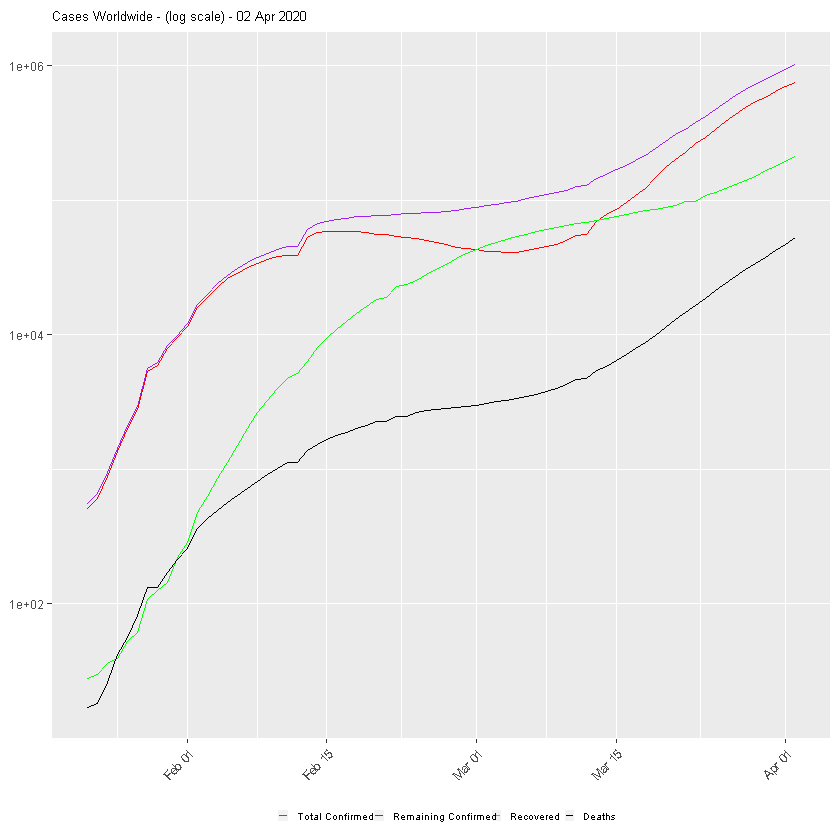

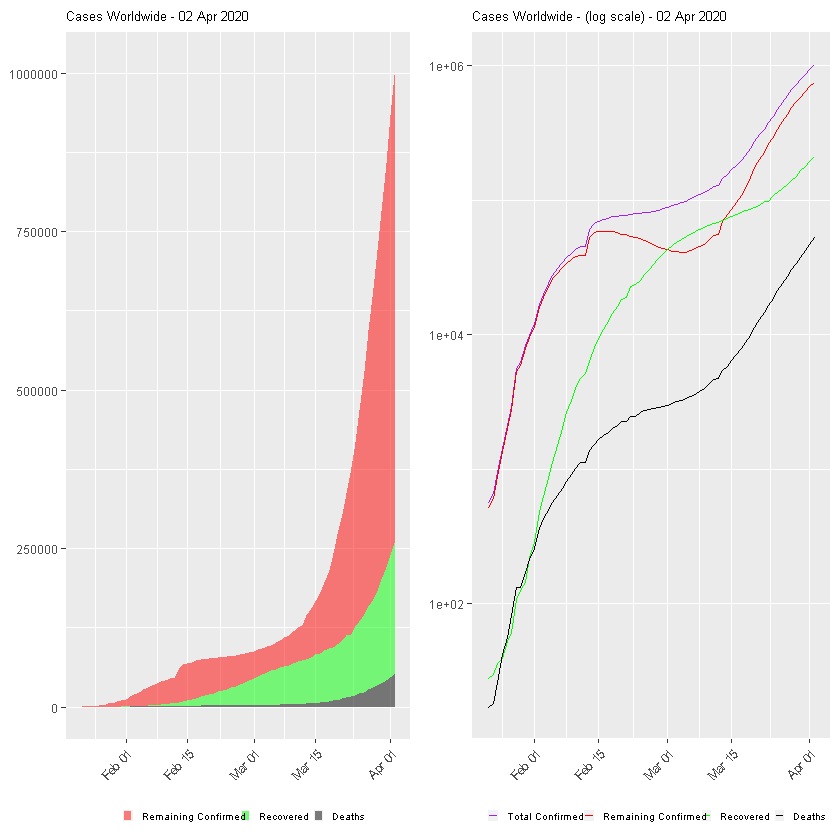

In [10]:
     # area plot 
plot1 <- world.long %>% filter(type != 'Total Confirmed') %>%
  ggplot(aes(x=date, y=count)) +
  geom_area(aes(fill=type), alpha=0.5) + 
  labs(title=paste0('Cases Worldwide - ', max.date.txt)) +
  scale_fill_manual(values=c('red', 'green', 'black')) +
  theme(legend.title=element_blank(), legend.position='bottom',
        plot.title = element_text(size=8),
        axis.title.x=element_blank(),
        axis.title.y=element_blank(),
        legend.key.size=unit(0.2, 'cm'),
        legend.text=element_text(size=6),
        axis.text=element_text(size=7),
        axis.text.x=element_text(angle=45, hjust=1))


plot2 <- world.long %>%
  ggplot(aes(x=date,y=count)) +
  geom_line(aes(color=type)) + 
  labs(title = paste0('Cases Worldwide - (log scale) - ', max.date.txt)) +
  scale_color_manual(values=c('purple', 'red', 'green', 'black')) +
  theme(legend.title=element_blank(), legend.position='bottom',
        plot.title = element_text(size =8),
        axis.title.x=element_blank(),
        axis.title.y = element_blank(),
        legend.key.size = unit(0.2, 'cm'),
        legend.text = element_text(size =6),
        axis.text = element_text(size = 7),
        axis.text.x =element_text(angle = 45, hjust = 1)) + 
  scale_y_continuous(trans = 'log10')

plot2
grid.arrange(plot1, plot2, ncol=2)

List of 1
 $ axis.text.x:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : NULL
  ..$ hjust        : num 1
  ..$ vjust        : NULL
  ..$ angle        : num 45
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

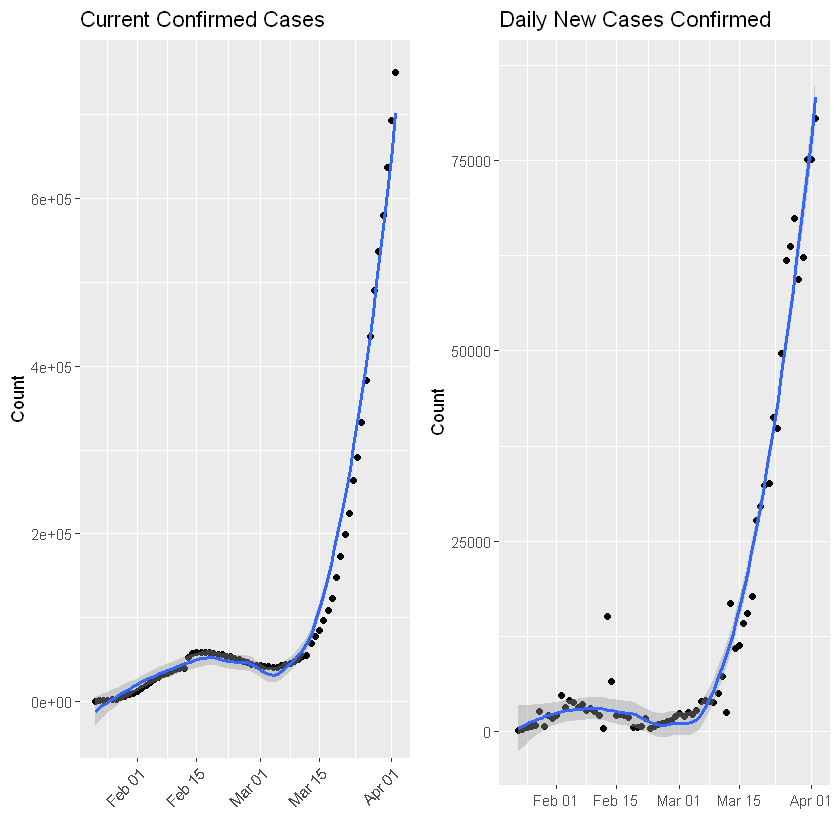

In [11]:
data.world <- data %>% filter(country == 'World')
n <- nrow(data.world)

##current confirmed and daily new confirmed
plot1 <- ggplot(data.world, aes(x=date, y=remaining.confirmed)) +
  geom_point()+geom_smooth()+
  xlab('') + ylab('Count') + labs(title = 'Current Confirmed Cases') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

plot2 <- ggplot(data.world, aes(x=date, y=confirmed.new))+ geom_point() + geom_smooth() + xlab('') + ylab('Count') + labs(title = 'Daily New Cases Confirmed')
  theme(axis.text.x = element_text(angle =45, hjust=1))

grid.arrange(plot1, plot2, ncol=2)

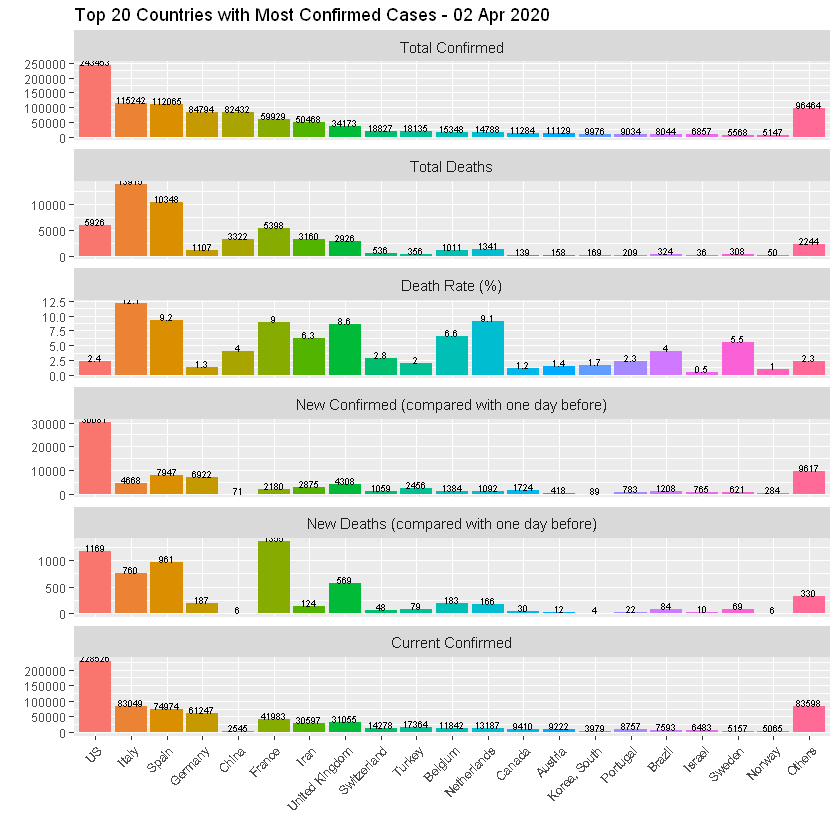

In [12]:
data.latest.long <- data.latest %>% filter(country!='World') %>% gather(key=type, value=count, -country)


data.latest.long %<>% mutate(type=recode_factor(type, confirmed='Total Confirmed', deaths='Total Deaths', death.rate='Death Rate (%)', confirmed.new='New Confirmed (compared with one day before)', deaths.new='New Deaths (compared with one day before)', remaining.confirmed='Current Confirmed'))

## bar chart
data.latest.long %>% ggplot(aes(x=country, y=count, fill=country, group=country)) +
  geom_bar(stat='identity') + 
  geom_text(aes(label=count, y=count),size=2, vjust=0) +
  xlab('') + ylab('') +
  labs(title=paste0('Top 20 Countries with Most Confirmed Cases - ', max.date.txt))+ scale_fill_discrete(name='Country', labels=aes(count)) +
  theme(legend.title=element_blank(),
        legend.position='none',
        plot.title=element_text(size=11),axis.text=element_text(size=7), axis.text.x=element_text(angle=45, hjust=1)) + facet_wrap(~type, ncol=1, scales='free_y')


Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Transformation introduced infinite values in continuous y-axis"

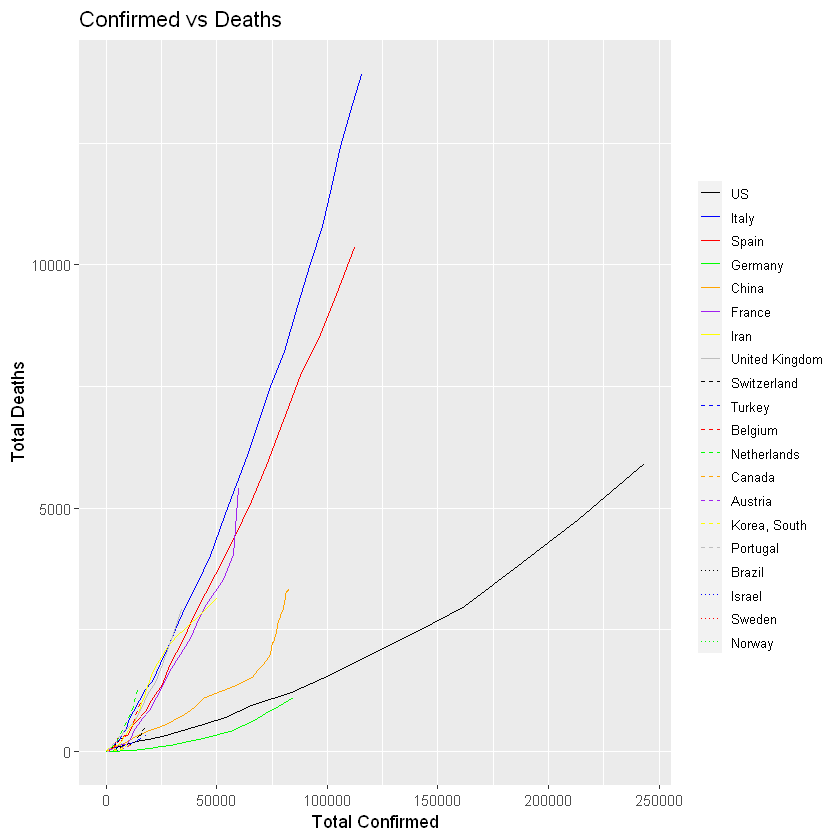

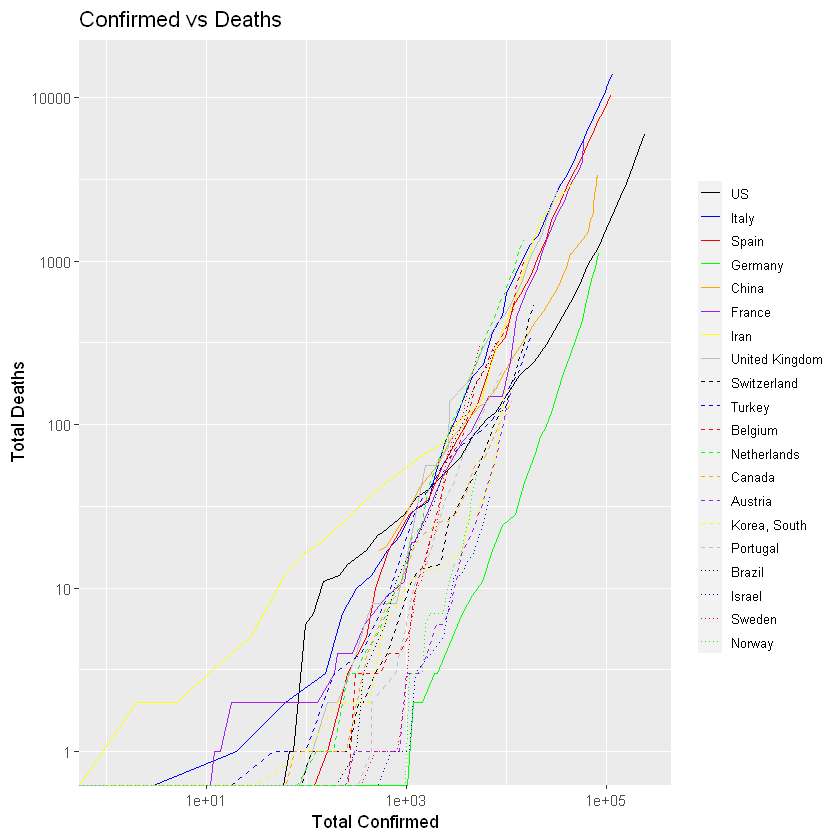

In [13]:
# Confirmed versus Deaths
linetypes <- rep(c("solid", "dashed", "dotted"), each=8)
colors <- rep(c('black', 'blue', 'red', 'green', 'orange', 'purple', 'yellow', 'grey'), 3)
df <- data %>% filter(country %in% setdiff(top.countries, c('World', 'Others'))) %>%
mutate(country=country %>% factor(levels=c(top.countries)))
vs <- df %>% ggplot(aes(x=confirmed, y=deaths, group=country)) +
  geom_line(aes(color=country, linetype=country)) +
  xlab('Total Confirmed') + ylab('Total Deaths') +
  scale_linetype_manual(values=linetypes) +
  scale_color_manual(values=colors) +
  theme(legend.title=element_blank(),
        legend.text=element_text(size=8),
        legend.key.size=unit(0.5, 'cm')) + ggtitle('Confirmed vs Deaths')
vs
vs + scale_x_log10() + scale_y_log10()


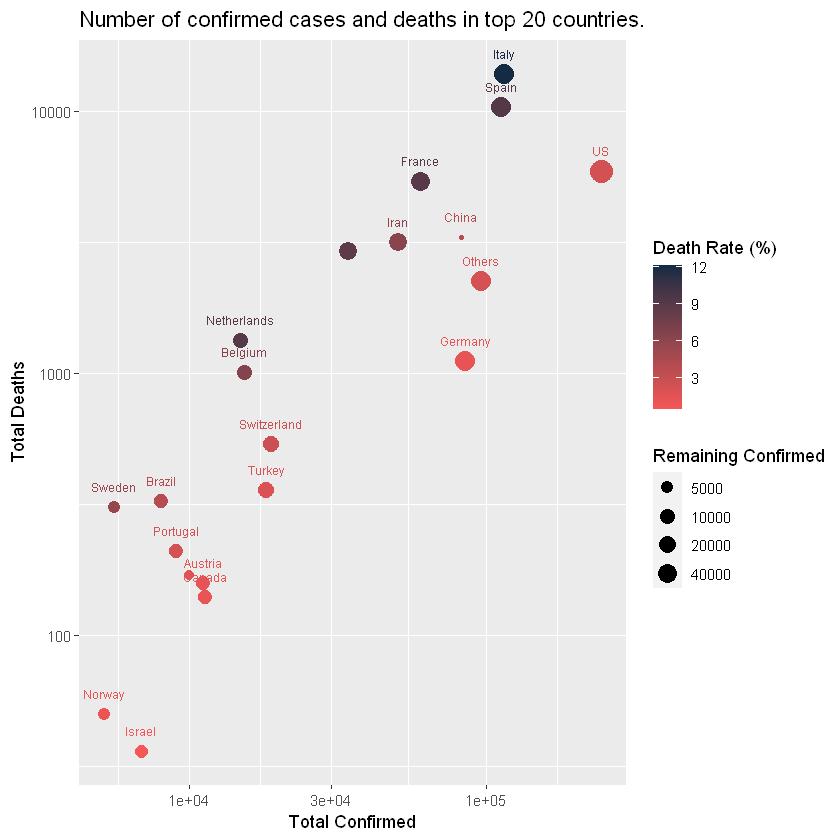

In [14]:
df <- data.latest %>% filter(country %in% setdiff(top.countries, 'World'))

plot1 <- df %>% ggplot(aes(x=confirmed, y=deaths, col=death.rate, size=remaining.confirmed)) + ggtitle('Number of confirmed cases and deaths in top 20 countries.') +
scale_size(name='Remaining Confirmed', trans='log2', breaks=c(1e3, 2e3, 5e3, 1e4, 2e4, 4e4)) +
geom_text(aes(label=country), size=2.5, check_overlap=T, vjust=-1.6) +
geom_point() +
xlab('Total Confirmed') + ylab('Total Deaths') +
labs(col="Death Rate (%)") +
scale_color_gradient(low='#f75656', high='#132B43') +
scale_x_log10() + scale_y_log10()
plot1

Warning message:
"Transformation introduced infinite values in continuous y-axis"

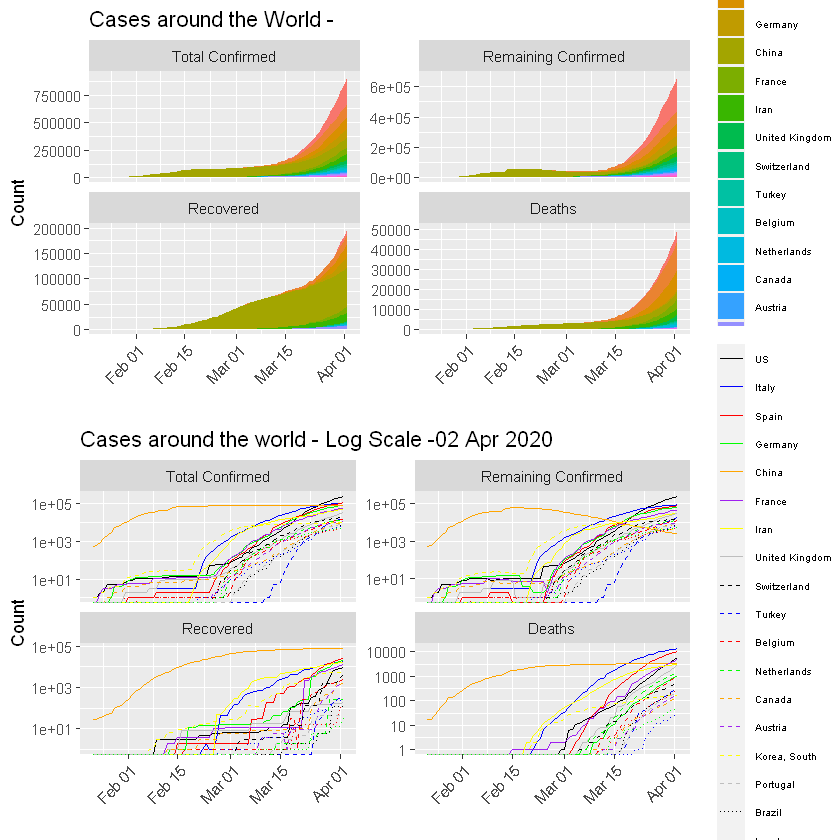

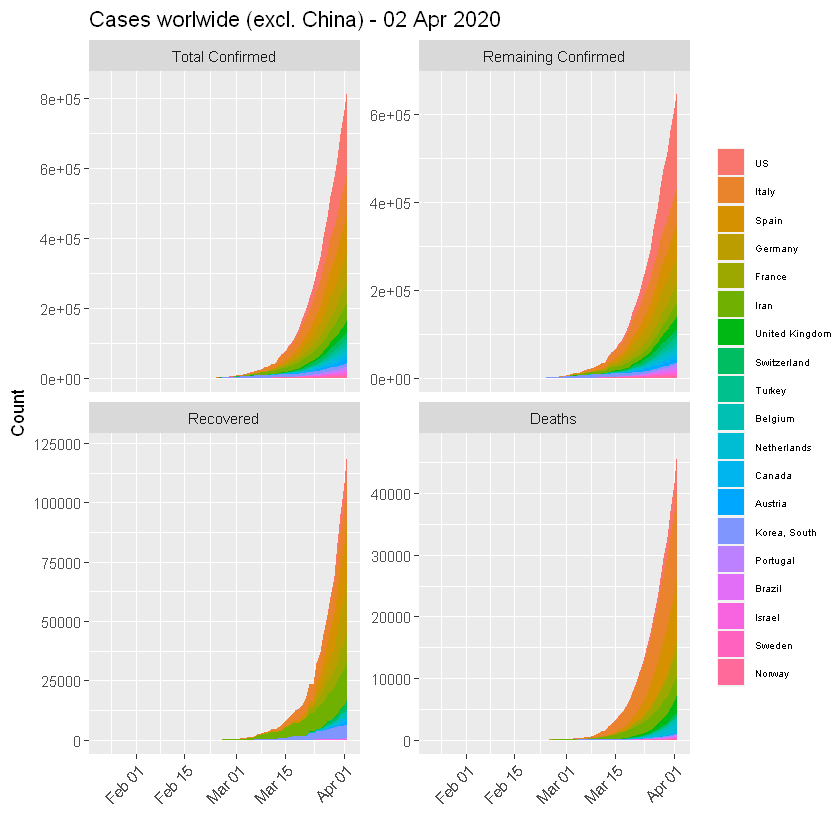

In [15]:

df <- data.long %>% filter(country %in% top.countries) %<>% mutate(country=country %>% factor(levels=c(top.countries)))

### CASES AROUND WORLD
p <- df%>% filter(country !='World') %>%
  ggplot(aes(x=date, y=count)) + xlab('') + ylab('Count') +
  theme(legend.title=element_blank(),
        legend.text = element_text(size=6),
        legend.key.size=unit(0.6, 'cm'),
        axis.text.x=element_text(angle = 45, hjust=1)) +
  facet_wrap(~type, ncol = 2, scale='free_y')
# area plot
plot1 <- p + geom_area(aes(fill=country)) +
  labs(title='Cases around the World - ', max.date.txt)

# line plot and in log scale
#linetypes <- rep(c('solid','dashed','dotted'), each=8)
#colors <- rep(c('black','blue','red','green','orange', 'purple', 'yellow', 'grey'), 3)
plot2 <- p + geom_line(aes(color=country, linetype=country)) +
  scale_linetype_manual(values = linetypes) +
  scale_color_manual(values = colors) +
  labs(title =paste0('Cases around the world - Log Scale -', max.date.txt)) +
  scale_y_continuous(trans = 'log10')
grid.arrange(plot1, plot2, ncol=1)


# Plot: excluding China
p <- df%>% filter(!(country %in% c('World', 'China'))) %>%
  ggplot(aes(x=date, y=count)) + xlab('') + ylab('Count') +
  theme(legend.title=element_blank(),
        legend.text = element_text(size=6),
        legend.key.size=unit(0.6, 'cm'),
        axis.text.x=element_text(angle = 45, hjust=1)) +
  facet_wrap(~type, ncol = 2, scale='free_y')
p + geom_area(aes(fill=country)) +
  labs(title=paste0('Cases worlwide (excl. China) - ', max.date.txt))


Warning message:
"Removed 36 row(s) containing missing values (geom_path)."

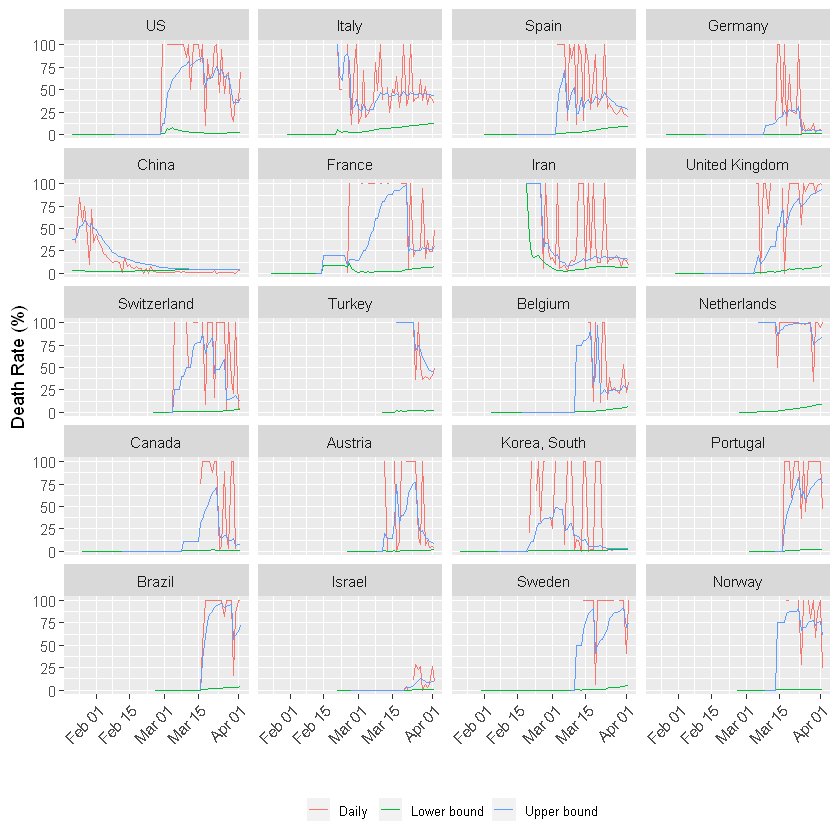

In [16]:
rate.max <- rates.long$count %>% max(na.rm=T)

df <- rates.long %>% filter(country %in% setdiff(top.countries, 'World')) %>%
  mutate(country=factor(country, levels=top.countries))

df %>% ggplot(aes(x=date, y=count, color=type)) +
  geom_line() +
  xlab('') + ylab('Death Rate (%)') +
  theme(legend.position='bottom', legend.title=element_blank(),
        legend.text=element_text(size=8),
        legend.key.size=unit(0.5, 'cm'),
        axis.text.x=element_text(angle=45, hjust=1)) +
ylim(c(0, 100)) +
facet_wrap(~country, ncol=4)


In [17]:
# Latest Cases by Country - TOP confirmed cases
## sort the latest data by death rate, and if tie, by confirmed
df <- data %>% filter(date == max(date) & country != 'World' & confirmed >= 100) %>% 
  select(country, confirmed, confirmed.new, remaining.confirmed,
         recovered, deaths, deaths.new, death.rate=rate.lower) %>%
  arrange(desc(death.rate, confirmed))

df %>% head(20) %>%
mutate(death.rate=death.rate %>% format(nsmall=1) %>% paste0('%')) %>%
  kable('latex', booktabs=T, row.names=T, align=c('l', rep('r', 7)),
        caption=paste0('Top 20 Countries with Highest Death Rates - ', max.date.txt), format.args=list(big.mark=',')) %>%
kable_styling(font_size=7, latex_options=c('striped', 'hold_position', 'repeat_header'))


\begin{table}[!h]

\caption{\label{tab:}Top 20 Countries with Highest Death Rates - 02 Apr 2020}
\centering
\fontsize{7}{9}\selectfont
\begin{tabular}[t]{llrrrrrrr}
\toprule
  & country & confirmed & confirmed.new & remaining.confirmed & recovered & deaths & deaths.new & death.rate\\
\midrule
\rowcolor{gray!6}  1 & San Marino & 245 & 9 & 194 & 21 & 30 & 4 & 12.2\%\\
2 & Italy & 115,242 & 4,668 & 83,049 & 18,278 & 13,915 & 760 & 12.1\%\\
\rowcolor{gray!6}  3 & Congo (Kinshasa) & 134 & 25 & 118 & 3 & 13 & 4 & 9.7\%\\
4 & Indonesia & 1,790 & 113 & 1,508 & 112 & 170 & 13 & 9.5\%\\
\rowcolor{gray!6}  5 & Spain & 112,065 & 7,947 & 74,974 & 26,743 & 10,348 & 961 & 9.2\%\\
\addlinespace
6 & Netherlands & 14,788 & 1,092 & 13,187 & 260 & 1,341 & 166 & 9.1\%\\
\rowcolor{gray!6}  7 & France & 59,929 & 2,180 & 41,983 & 12,548 & 5,398 & 1,355 & 9.0\%\\
8 & Algeria & 986 & 139 & 839 & 61 & 86 & 28 & 8.7\%\\
\rowcolor{gray!6}  9 & United Kingdom & 34,173 & 4,308 & 31,055 & 192 & 2,926 & 569 & 8.6\%\\


Note that this is an developing story. Check back for updates.